In [1]:
%matplotlib inline


In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data, wb
import datetime
import pickle

In [124]:
plt.style.use('default')

# Read Bonds

In [167]:
df=pd.read_excel('data/채권거래현황-v2.xls', thousands=',', index_col=0)
df_quant=df[df[u'구분']==u'거래량']
df_quant.head()

,구분,국채,지방채,특수채,통안증권,은행채,기타금융채,회사채,ABS,합계
거래일,,,,,,,,,,
2011-07-11,거래량,150907,151,5517,51387,9074,1976,2146,239,221397
2011-07-12,거래량,227466,80,10796,97975,18249,3578,3989,1105,363238
2011-07-13,거래량,175842,631,6818,73927,18430,4176,3805,11,283640
2011-07-14,거래량,172789,412,4130,65921,22131,3234,2273,1219,272109
2011-07-15,거래량,132172,152,5593,54730,16087,2252,4855,805,216646


# Fetch KOSPI from Google

In [189]:
start = datetime.datetime(2011, 7, 11)
end = datetime.datetime(2016, 7, 11)

In [190]:
# Open 	High 	Low 	Close 	Volume
f = web.DataReader("KOSPI", 'google', start, end)
f.sort_index()
output = open('data/KOSPI-20110711-20160711.pkl', 'wb')
pickle.dump(f, output)
output.close()

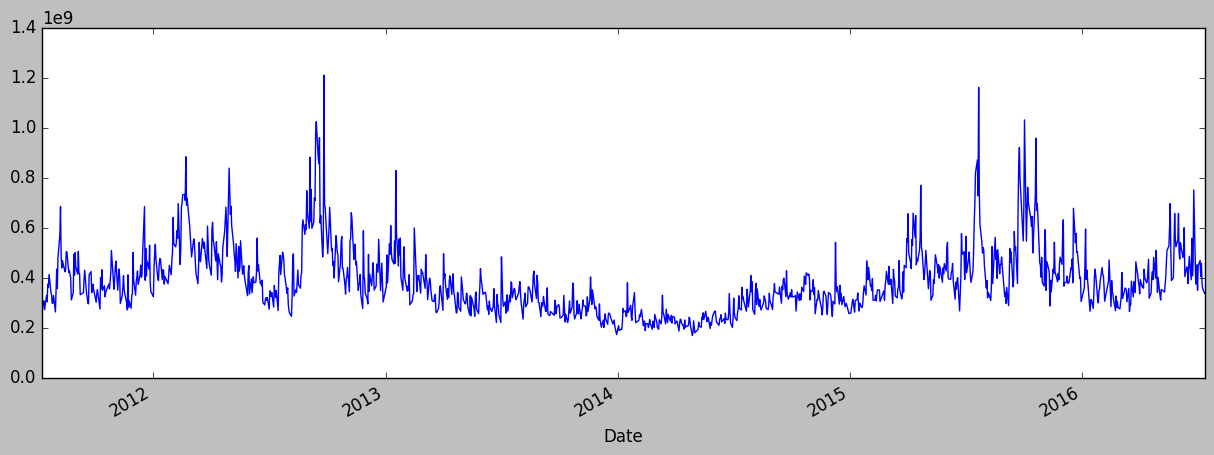

In [193]:
f[u'Volume'].plot(figsize=(15, 5))

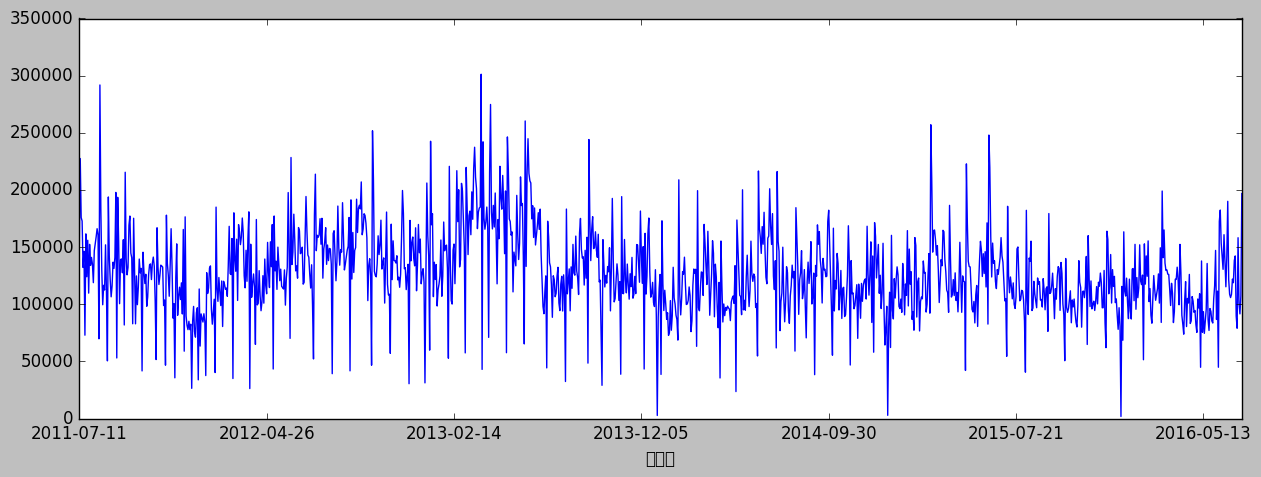

In [191]:
df_quant[u'국채'].plot(figsize=(15, 5))

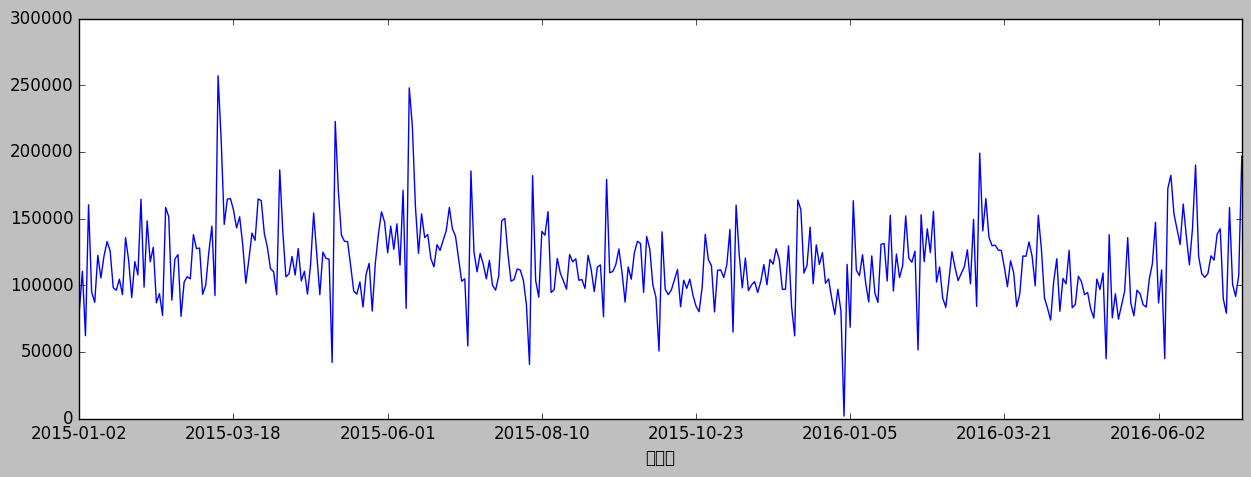

In [165]:
df_quant2=df_quant[df_quant.index > '2015-01-01']
df_quant2[u'국채'].plot(figsize=(15, 5))

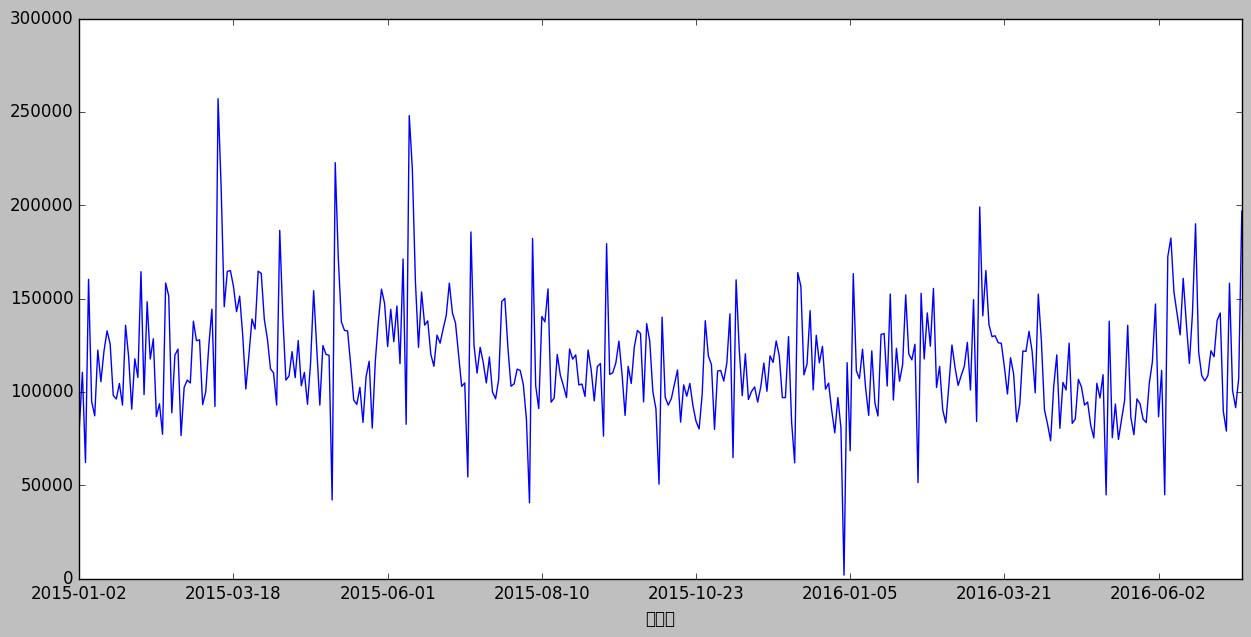

In [197]:
plt.figure(figsize=(15, 7))
df_quant2[u'국채'].plot()
#df_quant2.columns